# Solving the Inventory Model

#### John Stachurski

### Prepared for the CBC QuantEcon Workshop (September 2022)

We solve the inventory model discussed in the lecture slides using value function iteration (VFI).

We will use the following imports.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from numba import njit, int32

At present `np.argmax` doesn't play well with Numba, so let's roll our own jitted
version (an argmax function for lists):

In [32]:
@njit
def argmax(list_object):
    "Return the index of the largest element of `list_object`."
    max_val = -np.inf
    argmax_index = None
    for i, x in enumerate(list_object):
        if x > max_val:
            max_val = x
            argmax_index = i
    return argmax_index

We also use the `successive_approx` function, as defined below.

In [33]:
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False):        
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

## Primitives and functions

To store our model parameters we use a namedtuple.  Here we define the namedtuple and a function to create instances, with default values.

In what follows, we assume that demand follows the Geometric distribution on $0, 1, \ldots$

In [70]:
Model = namedtuple('Model', ('β', 'K', 'c', 'κ', 'p', 'ϕ', 'Γ'))

In [87]:
def create_inventory_model(r=0.02,     # interest rate
                           K=40,       # maximum inventory
                           c=0.2, κ=2, # cost paramters
                           p=0.6):     # demand parameter
    β = 1/(1 + r)
    
    @njit
    def ϕ(d):
        "Geometric distribution on d = 0, 1, 2,... with parameter p."
        return (1 - p)**d * p   
    
    @njit
    def Γ(x):
        "The feasible correspondence"
        return range(K - x + 1)   # integers 0,...,K

    return Model(β=β, K=K, c=c, κ=κ, p=p, ϕ=ϕ, Γ=Γ)

The next function is the unmaximized right-hand side of the Bellman equation, which is

$$
\begin{aligned}
    B(x, a, v)
    & := r(x, a) + \beta \sum_d v[ F(x, a, d) ] \phi(d) \\ 
    & = \text{ profit } + \beta \text{ continuation value}
\end{aligned}
$$

In [88]:
@njit
def B(x, a, v, model, d_max=100):
    "The function B(x, a, v)"
    β, K, c, κ, p, ϕ, Γ = model
    expected_revenue = sum([min(x, d)*ϕ(d) for d in range(d_max)])
    profit = expected_revenue - c * a - κ * (a > 0)
    continuation_value = sum([v[max(x - d, 0) + a]*ϕ(d) for d in range(d_max)])
    return profit + β * continuation_value

Now we introduce the Bellman operator.

In [89]:
@njit
def T(v, model):
    "The Bellman operator."
    β, K, c, κ, p, ϕ, Γ = model
    new_v = np.empty_like(v)
    for x in range(K + 1):
        new_v[x] = max([B(x, a, v, model) for a in Γ(x)])
    return new_v

### Exercise

Write a function that computes $v$-greedy policies from any given $v$.  Use the `argmax` function defined above and apply `@njit` to make it fast.

In [90]:
# Put your code here

In [91]:
for _ in range(12):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [92]:
@njit
def get_greedy(v, model):
    β, K, c, κ, p, ϕ, Γ = model
    σ = np.empty_like(v, dtype=int32)
    for x in range(K + 1):
        σ[x] = argmax([B(x, a, v, model) for a in Γ(x)])
    return σ

## Tests and calculations

The function below applies value function iteration to solve the model.

In [77]:
def vfi(v_init, model):
    v_star = successive_approx(lambda v: T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

Let's put these functions to work:

In [78]:
model = create_inventory_model()

In [79]:
β, K, c, κ, p, ϕ, Γ = model
v_init = np.zeros(K + 1)

Here we compute the optimal policy and value function using VFI.

In [80]:
v_star, σ_star = vfi(v_init, model)

First we will look at the policy and value functions.

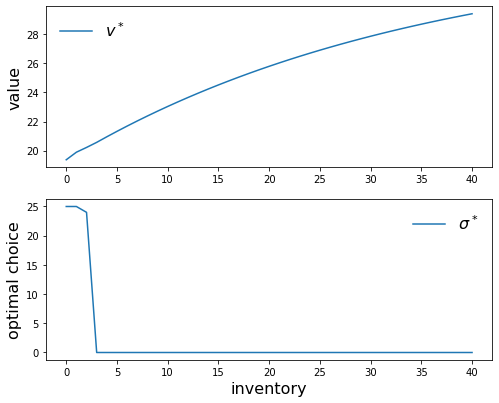

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))
fontsize=16

ax = axes[0]
ax.plot(range(K + 1), v_star, label="$v^*$")
ax.set_ylabel("value", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)

ax = axes[1]
ax.plot(range(K + 1), σ_star, label="$\\sigma^*$")
ax.set_xlabel("inventory", fontsize=fontsize)
ax.set_ylabel("optimal choice", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)
plt.show()

### Exercise

Write a function to simulate inventories under the optimal policy.  The function should be JIT compiled and take as arguments

* `model`, which is a namedtuple as above
* `σ_star`, which is an optimal policy for `model`
* `ts_length`, an integer for the length of the time series
* `X_init`, which is an initial value for the state

In [82]:
# Put your code here

In [83]:
for _ in range(12):
    print('solutions below')

solutions below
solutions below
solutions below
solutions below
solutions below
solutions below
solutions below
solutions below
solutions below
solutions below
solutions below
solutions below


In [84]:
@njit
def sim_inventories(model, σ_star, ts_length=100, X_init=0):
    "Simulate given the optimal policy."
    X = np.zeros(ts_length, dtype=int32)
    X[1] = X_init
    for t in range(ts_length-1):
        D = np.random.geometric(model.p) - 1  # subtract 1 to get a draw on 0, 1, ...
        X[t+1] = max(X[t] - D, 0) + σ_star[X[t]]
    return X

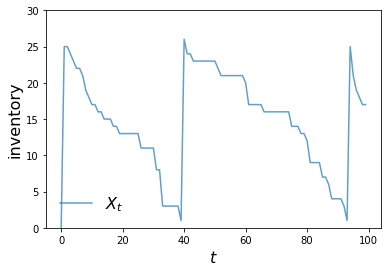

In [86]:
X = sim_inventories(model, σ_star)
fig, ax = plt.subplots()
ax.plot(X, label="$X_t$", alpha=0.7)
ax.set_xlabel("$t$", fontsize=fontsize)
ax.set_ylabel("inventory", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)
ax.set_ylim(0, np.max(X)+4)
plt.show()